# Vasicek Model



SDE of Vasicek model:

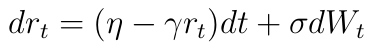

Vasicek model is a mean reverting process : Interest rates tend to drift towards its long-term mean

Gamma : The mean reverting speed

Eta / Gamma : the long-term mean rate

σ : Volatility

It defines the short term rate process rt as

 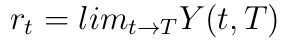

The resolution of DSE shows that r_t can be written

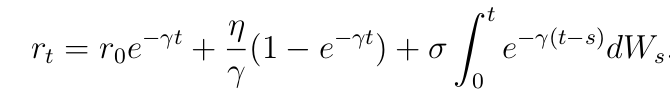

The expected value and the variance of rt are as follow :

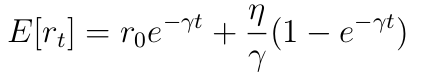

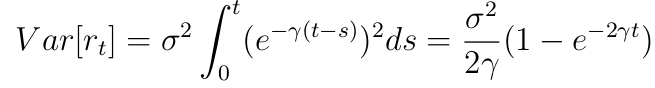



The Vasicek Model possess an affine term structure (ATS) where P(r,t, T) is the ZC bond price with maturity T at time t

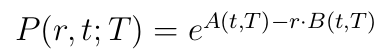

As The bond price in the vasicek model satisfies the following partial differential equation:
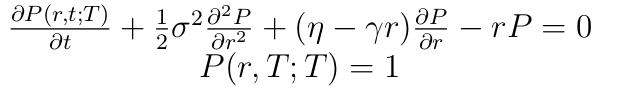

It follows that, assuming τ = T -t is the time to maturity

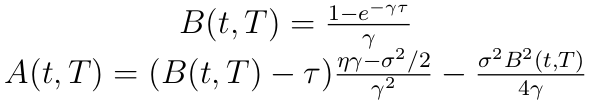

Furthermore, the zero coupon bond's price in continous compounding

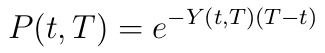

we can write

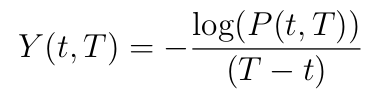

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cmath

In [11]:
def B(t, T, gamma):

    Tau = T - t
    return (1-math.exp(-gamma * Tau))/gamma

def A(t, T, gamma, etha, sigma):

    Tau = T - t
    return (B(t, T, gamma) - Tau) * (gamma * etha - 0.5 * (sigma**2))/(gamma**2) - ((sigma * B(t, T, gamma))**2)

In [16]:
def Y(r, t, T, gamma, etha, sigma):

    Tau = T - t
    if (T - t) == 0:
        return 1
    else:
        return - (A(t, T, gamma, etha, sigma) - r * B(t, T, gamma)) / Tau


In [36]:
def Yield(gamma=0.25, etha=0.25 * 0.03, sigma=0.02, r=0.05):

    T = np.zeros(31) ## maturity
    Yield = np.zeros(31)
    Yield2 = np.zeros(31)

    for i in range(31):
        T[i] = i + 1
        Yield[i] = Y(r, 0, T[i], gamma, etha, sigma)
        Yield2[i] = Y(0.01, 0, T[i], gamma, etha, sigma)

    plt.figure(figsize=(16,8))
    plt.title('Term Structure under Vasicek model')
    plt.plot(T, Yield, label="Inverted term structure with r = 0.05")
    plt.plot(T, Yield2, label="Upward_sloping term structure r = 0.01")
    plt.xlabel('Time to maturity')
    plt.ylabel('Yield')
    plt.legend()


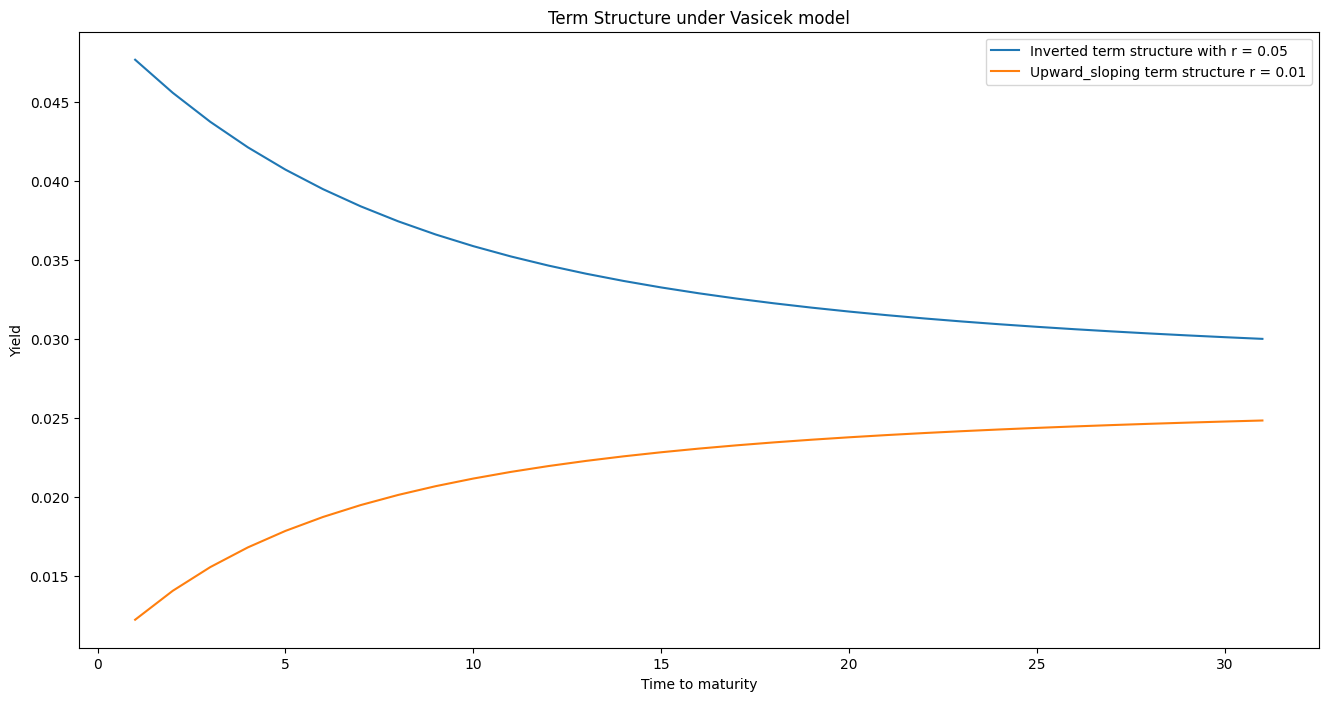

In [37]:
Yield()

We can notice that both curves are converging  to the quantity (etha / Gamma) = 0.03 which represents the long-mean rate of the model

Now we are going to calibrate the model coefficient based on a Yield Curve from the market using Levenberg-Marquart's algorithm

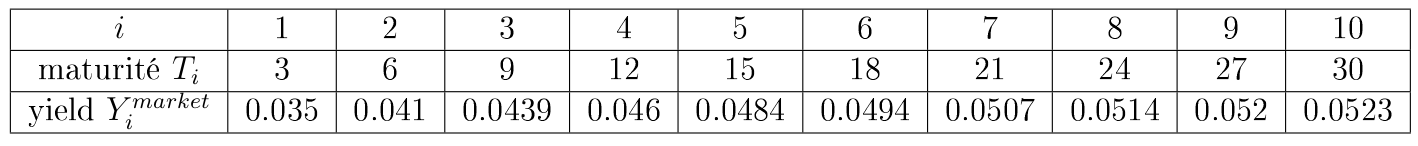

In [40]:
def derivee_B(t, T, gamma):

    Tau = T - t
    return (Tau * math.exp(-gamma * Tau) - B(t, T, gamma)) / gamma

def derivee_A(t,T,gamma, etha, sigma):

    Tau = T - t
    return (1 / (gamma**2)) * (etha * (derivee_B(t, T, gamma) * gamma - B(t, T, gamma) ) + Tau * etha - (sigma**2) * (derivee_B(t, T, gamma) - 2 * B(t, T, gamma) / gamma)/2 - (sigma**2) * Tau / gamma - (sigma**2) * (B(t, T, gamma)/ 4) * (2 * gamma * derivee_B(t, T, gamma) - B(t, T, gamma) ) )


def derivee_etha(t, T, gamma):

    Tau = T - t
    return (B(t, T, gamma) - Tau) / (Tau * gamma)


def derivee_sigma_carre(t, T,gamma):

    Tau = T - t
    return - ((B(t, T, gamma) - Tau) / (2 * gamma) + (B(t, T, gamma) / 2)**2) / (Tau * gamma)

def derivee_gamma(r, t, T, gamma, etha, sigma):

    Tau = T - t
    return (derivee_A(t, T, gamma, etha, sigma) - r * derivee_B(t, T, gamma)) / Tau

In [48]:
def Vasicek(r = 0.05, epsilon = 0.000000001, Lamda = 0.01):

    Y_Mar = [0.035, 0.041, 0.0439, 0.046, 0.0484, 0.0494, 0.0507, 0.0514, 0.052, 0.0523] ## donnée du marché
    Y_Mar1 = [0.056, 0.064, 0.074, 0.081, 0.082, 0.09, 0.087, 0.092, 0.0895, 0.091]
    T = np.array([3, 6, 9, 12, 15, 18, 21, 24, 27, 30]) ## Vecteur de taille 10
    Y_th =[]
    Res = []
    J = np.zeros((10, 3))


    Identite = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    D = np.array([[1, 1, 1]]).T
    etha = 1
    gamma = 1
    sigma_carre = 1

    k = 0
    while (np.linalg.norm(D) > epsilon) :

        #print(np.linalg.norm(D))


        for p in range(10):

            Y_th.append(Y(r, 1, T[p], gamma, etha, cmath.sqrt(sigma_carre)))
            Res.append(Y_Mar1[p] - Y_th[p])
            Res_Matrix = np.array([Res]).T ## changer en matrice
            J[p][0] = derivee_etha(1, T[p], gamma)
            J[p][1] = derivee_sigma_carre(1, T[p], gamma)
            J[p][2] = derivee_gamma(r, 1, T[p], gamma, etha, cmath.sqrt(sigma_carre))

        D = - (np.linalg.inv(J.T@ J+ Lamda * Identite))@ J.T @ Res_Matrix  ## Produit matriciel

        J = np.zeros((10, 3))
        Y_th.clear()
        Res.clear()

        etha += D[0][0]
        sigma_carre += D[1][0]
        gamma += D[2][0]

        k = k + 1

    print(k)
    print("etha",etha,)
    print("sigma", cmath.sqrt(sigma_carre))
    print("gamma",gamma)


    ### Comparer Y_th et Y_Mar
    for i in range(10):
        Y_th.append(Y(r, 1, T[i], gamma, etha, cmath.sqrt(sigma_carre)))

    plt.figure(figsize=(16,8))
    plt.plot(T, Y_th, label="Yth" )
    plt.plot(T, Y_Mar1, '.', label="Y_Mar1")
    plt.legend()
    plt.title("Calibration of market Yield Curve under Vasicek model")


<ipython-input-48-65cc107164a7>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  J[p][2] = derivee_gamma(r, 1, T[p], gamma, etha, cmath.sqrt(sigma_carre))
<ipython-input-11-4e98dc2d8898>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  return (1-math.exp(-gamma * Tau))/gamma
<ipython-input-48-65cc107164a7>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  J[p][0] = derivee_etha(1, T[p], gamma)
<ipython-input-48-65cc107164a7>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  J[p][1] = derivee_sigma_carre(1, T[p], gamma)


3718
etha (0.020110938341501693+0j)
sigma 0.0853673158189767j
gamma (0.31639306396139755+0j)


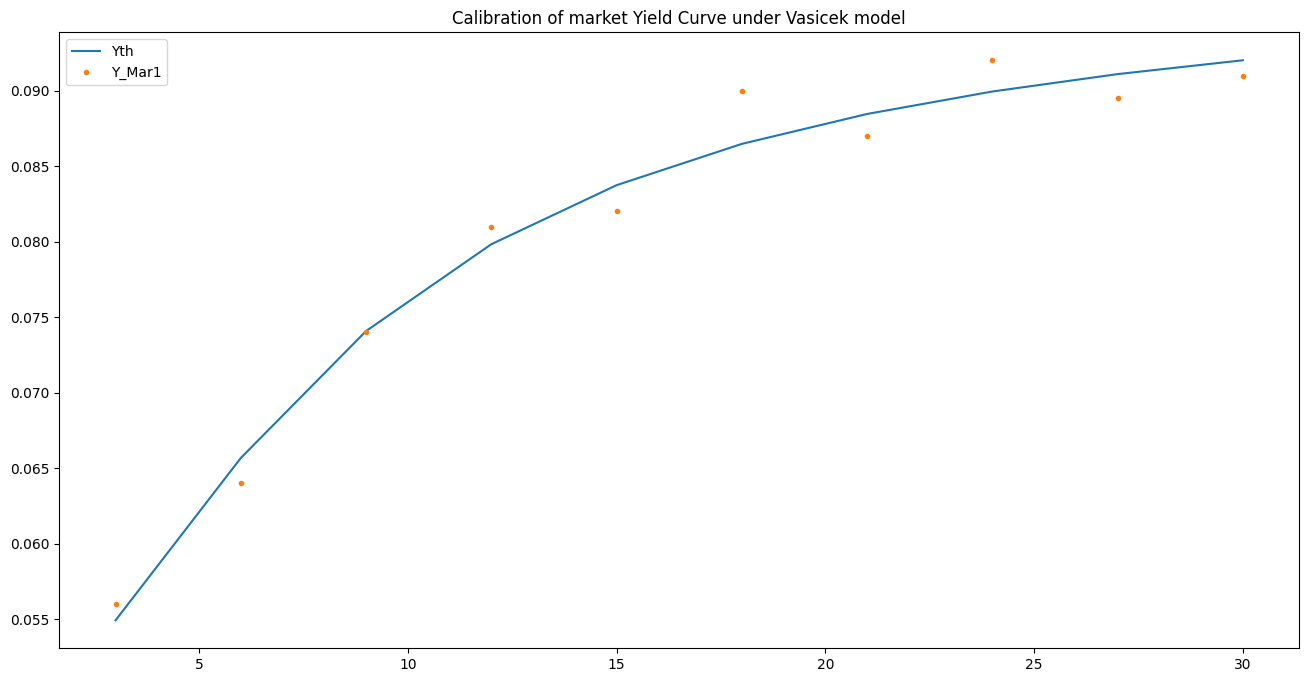

In [49]:
Vasicek()

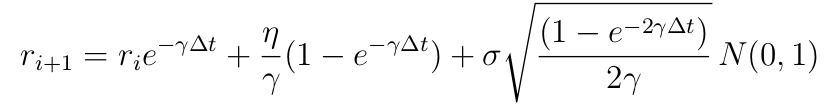

In [57]:
def calibration_hist_dates(T = 5, etha = 0.6, gamma = 4, sigma = 0.08, N = 100 ):

    delta_t = T/N
    X = []
    X_carre = []
    Y = []
    Y_th = []
    Z = []
    r = np.zeros(100)
    t = np.linspace(0, 1, 100)
    r[0] = 0.05

    for i in range(99):

        X.append(r[i])
        X_carre.append(r[i] ** 2)
        Y_th.append(X[i] * 0.8817867419193822 + 0.017808406981631)
        r[i+1] = r[i] * math.exp(-gamma * delta_t) + etha * (1 - math.exp(-gamma * delta_t))/gamma + sigma * math.sqrt((1 - math.exp(-2 * gamma * delta_t))/(2 * gamma)) * np.random.normal(0, 1)
        Y.append(r[i + 1])
        Z.append(r[i] * r[i + 1])


    plt.figure(figsize=(16,8))
    plt.plot(t, r)
    plt.xlabel("t")
    plt.ylabel("r")
    plt.title("Taux d'intéret en fct du temps")

    plt.figure(figsize=(16,8))
    plt.plot(X, Y, '.')
    plt.plot(X, Y_th, label="Linear Regression between r_i+1 and r_i")
    plt.xlabel("r_i")
    plt.ylabel("r_i+1")
    plt.legend()
    plt.title("Linear Regression between r_i+1 and r_i")
###
    beta1 = (sum(Z) - 0.01 * sum(Y) * sum(X)) / (sum(X_carre) - 0.01 * (sum(X) ** 2))
    beta2 = (sum(Y) * sum(X_carre) - sum(X) * sum(Z)) / (100 * sum(X_carre) - sum(X) ** 2)
    print("La valeur de Beta1 est:", beta1)
    print("La valeur de Beta2 est:", beta2)

    D_carre = 0
    for i in range(99):
        D_carre += 0.01 * (Y[i] - (beta1 * X[i] + beta2))**2
    print("D au carré est:",D_carre)

    gamma = - math.log(beta1) / delta_t
    etha = gamma * beta2 / (1 - beta1)
    sigma = cmath.sqrt(-D_carre * 2 * math.log(beta1) / (delta_t *(1 - beta1**2)))
    print("etha est : ",etha)
    print("gamma est:", gamma)
    print("sigma est :",sigma)

La valeur de Beta1 est: 0.8448761133194989
La valeur de Beta2 est: 0.02123943307394358
D au carré est: 0.00023377147089344907
etha est :  0.46159633164305636
gamma est: 3.371305476593754
sigma est : (0.07421417480772359+0j)


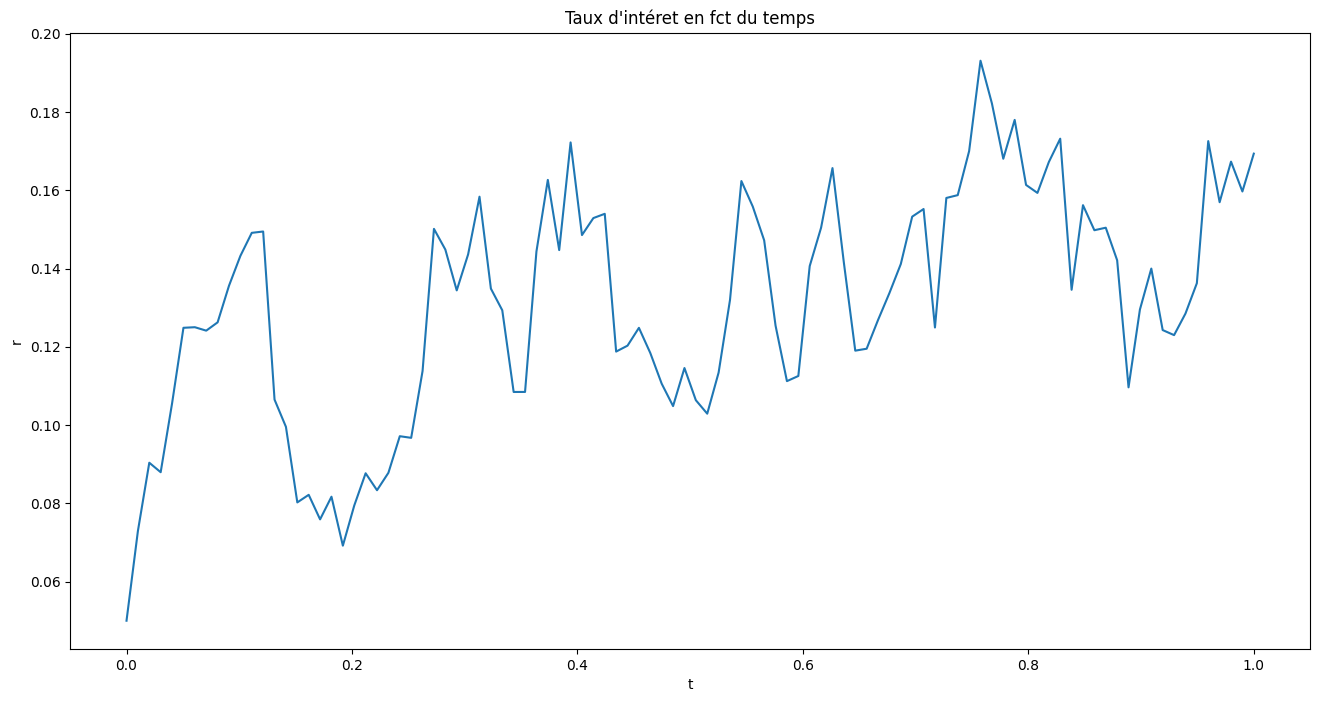

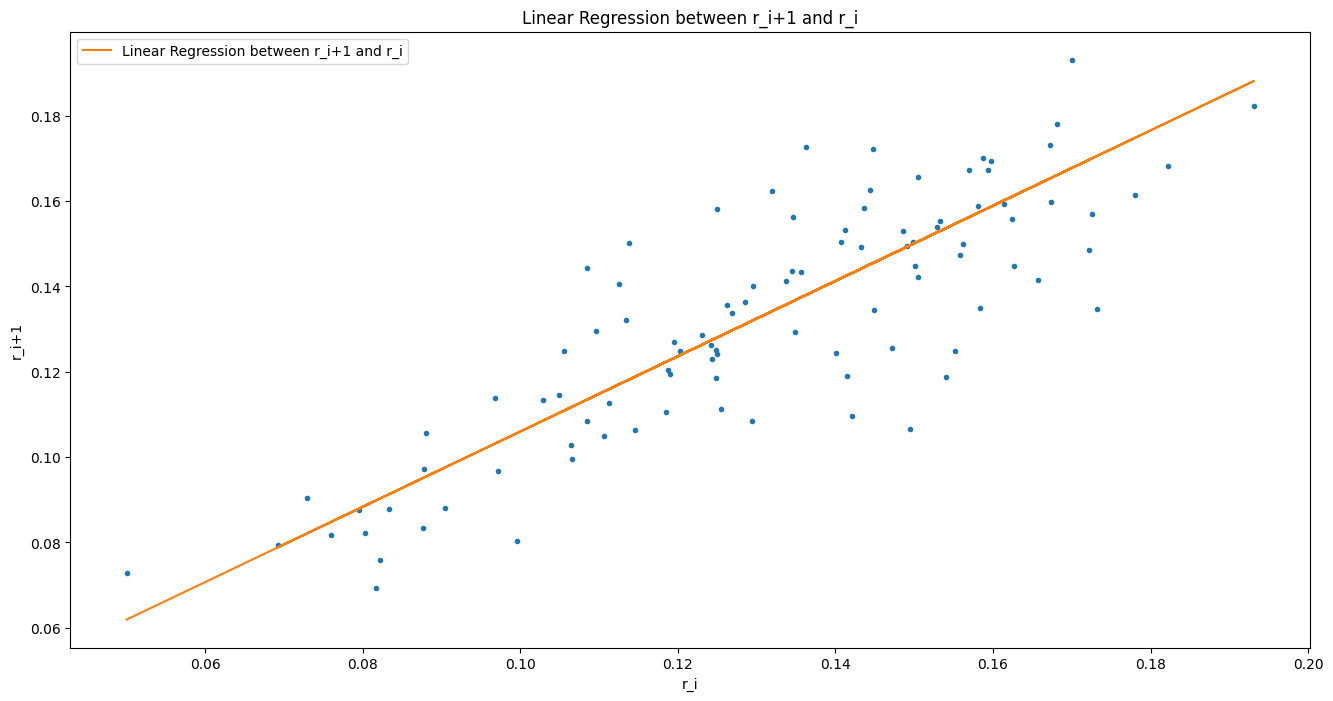

In [58]:
calibration_hist_dates()
